In [8]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from shapely import wkt
from libpysal import weights

from cycler import cycler
from matplotlib import pyplot as plt

# global plotting settings
plt.style.use(['ggplot'])


default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (15, 5)
                    })


In [11]:
glim = xr.open_dataset('./glim_wgs84_0point5deg_Raster.nc').to_dataframe().reset_index()
glim = glim.rename(columns={'glim_wgs84_0point5deg.tif' : 'glim',
                           'x' : 'longitude',
                           'y' : 'latitude'})

glim = gpd.GeoDataFrame(glim, 
                        geometry=gpd.GeoSeries.from_xy(glim.longitude, glim.latitude), 
                        crs='epsg:4326')

# replace missing data (-9999, 15, 0)
# ignore unconsol (1), metamorphic (8), pyroclastic (12), water bodies (11), evaporite (14), ice and glacier (16)
litho = ( glim.replace([-9999, 15, 0, 1, 11, 16, 8, 12, 14], np.nan)
              .replace([2, 4, 7, 9, 10, 13], 2)
              .replace([3, 5, 6], 3)
              .assign(contact = np.zeros(len(glim)))
        )

In [75]:
litho = gpd.read_file('litho0.geojson')

In [ ]:
wq = weights.contiguity.Queen.from_dataframe(litho)

contact1 = 2
contact2 = 3

for i in range(len(litho)):
    if (litho.glim.iloc[i] == contact1) & (litho.loc[wq.neighbors[i]].glim == contact2).any():
        litho.loc[i, 'contact1'] = True

for i in range(len(litho)):
    if (litho.glim.iloc[i] == contact2) & (litho.loc[wq.neighbors[i]].glim == contact1).any():
        litho.loc[i, 'contact2'] = True

In [ ]:
modis = (xr.open_dataset('./MOD11C3v6_LST_K_day&night_2000_2020_moclim/LSTdaytime_nc/MOD11C3v6_LST_K_daytime_2000_2020_MONTH_01.nc')
           .to_dataframe().reset_index()
        )

In [ ]:
rds = rxr.open_rasterio('./glim_wgs84_0point5deg_Raster.nc')

In [ ]:
modis_path = os.path.join('./MOD11C3v6_LST_K_day&night_2000_2020_moclim/LSTdaytime_nc/MOD11C3v6_LST_K_daytime_2000_2020_MONTH_01.nc')

In [48]:
modis = rxr.open_rasterio(modis_path, decode_coords='all')[0]

modis = modis.squeeze()
modis = modis.rio.write_crs('epsg:4326')

/home/otto/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/otto/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


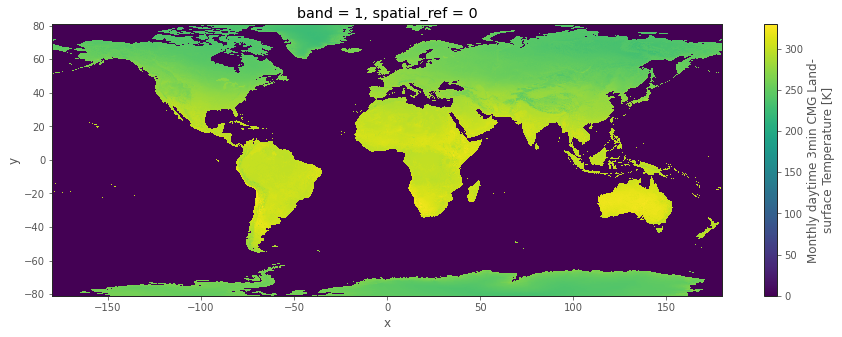

In [61]:
modis.MOD11C3_006_LST_Day_CMG.plot()

In [ ]:
# why takes so long?
modis_gdf = gpd.GeoDataFrame(modis.MOD11C3_006_LST_Day_CMG, 
                             geometry=litho.geometry, 
                             crs='epsg:4326')

In [76]:
litho.loc[:, 'modis_day'] = modis.MOD11C3_006_LST_Day_CMG

ValueError: cannot set using a multi-index selection indexer with a different length than the value

In [12]:
with rxr.open_rasterio(modis_path) as modis_src:
    modis = modis_src.read(1)

/home/otto/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/otto/anaconda3/lib/python3.8/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/home/otto/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/otto/anaconda3/lib/python3.8/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


AttributeError: __enter__

In [ ]:
modis = modis.rename(columns={'modis_wgs84_0point5deg.tif' : 'modis',
                           'x' : 'longitude',
                           'y' : 'latitude'})

modis = gpd.GeoDataFrame(modis, 
                        geometry=gpd.GeoSeries.from_xy(modis.longitude, modis.latitude), 
                        crs='epsg:4326')